In [1]:
import praw
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import os

In [49]:
# Authentication 
reddit = praw.Reddit(client_id=os.getenv[APP_ID],
                     client_secret=os.getenv[CLIENT_SECRET],
                     user_agent='Analysis Project')

In [50]:
# Define functions for future data scraping 

In [51]:
def get_posts(sub_name, n):
    subreddit = reddit.subreddit(sub_name)
    posts_list = [] 
    
    for submission in subreddit.top(limit=n):
        info_list = []
        info_list.append(submission.id)   # Output: the submission's title
        info_list.append(submission.score)  # Output: the submission's score  
        info_list.append(str(submission.author)) 
        info_list.append(submission.num_comments)
        info_list.append(submission.subreddit)
        posts_list.append(info_list)
    
    a = sorted(posts_list, key=lambda x: x[1], reverse = True)
    posts_df = pd.DataFrame(a, columns = ['id', 'score', 'author', 'num_comments', 'subreddit'])
    return posts_df

In [52]:
def get_comments(subm_id, n): 
    
    com_list = []
    submission = reddit.submission(id = subm_id)
    i = 0
    for comment in submission.comments:
        info_list = []
            # Top 3 comments for each submission
        if i <= n:
            info_list.append(comment.id)
            info_list.append(comment.score)
            info_list.append(comment.author)
            info_list.append(submission.subreddit)
            #info_list.append(submission.comments.list()[i].body)
            i += 1
            com_list.append(info_list)
        else:
            break
    
    a = sorted(com_list, key=lambda x: x[1], reverse = True)
    com_df = pd.DataFrame(a)
    return com_df   

In [53]:
def get_user_posts(author, n):
    
    redditor = reddit.redditor(author)
    user_posts_list = []
    
    for submission in redditor.submissions.top(limit = n):
        info_list = []
        info_list.append(submission.id)
        info_list.append(submission.score)
        info_list.append(str(submission.author))
        info_list.append(submission.num_comments)
        info_list.append(str(submission.subreddit))
        user_posts_list.append(info_list)
    
    a = sorted(user_posts_list, key=lambda x: x[1], reverse = True)
    user_posts_df = pd.DataFrame(a)
    return user_posts_df 

# Initial Analysis of r/all

In [54]:
# First we scrape 1000 posts, then using submission id, scrape most popular comments of every post and append it to the 
# dataframe with comments 
df = get_posts('all', 1000)

In [55]:
df.shape # Explore posts dataframe

(1000, 5)

In [56]:
df.head(10)

,id,score,author,num_comments,subreddit
0,l8rf4k,487886,SomeGuyInDeutschland,13999,wallstreetbets
1,haucpf,438832,ReallyRickAstley,18946,pics
2,62sjuh,437495,serventofgaben,5150,movies
3,gyfedz,411375,rextraneous,4322,memes
4,jptqj9,365123,throwawaynumber53,28333,news
5,ig9u4z,343764,BlackAdder7,3326,memes
6,l6wu59,338203,vrweensy,12850,wallstreetbets
7,90bu6w,336112,FootLoosePickleJuice,4383,aww
8,7mjw12,308581,the_Diva,2450,funny
9,fj45ih,301444,theonlymexicanman,1991,memes


In [57]:
df.author.nunique()

818

In [58]:
df.subreddit.nunique()

58

In [59]:
df['score'].describe()

count      1000.000000
mean     176261.550000
std       34570.164408
min      144843.000000
25%      154762.000000
50%      166038.500000
75%      186091.500000
max      487886.000000
Name: score, dtype: float64

In [60]:
df['num_comments'].describe()

count     1000.000000
mean      3705.191000
std       4809.625991
min        363.000000
25%       1397.750000
50%       2322.500000
75%       4220.750000
max      81432.000000
Name: num_comments, dtype: float64

<Axes: xlabel='score', ylabel='num_comments'>

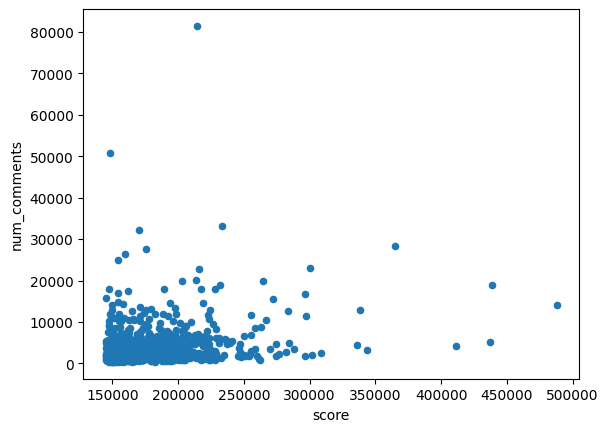

In [61]:
df.plot('score', 'num_comments', kind = 'scatter' )

# Analysis based on a r/marvelstudios

In [62]:
import matplotlib.pyplot as plt

In [63]:
marvel_df = get_posts('marvelstudios', 500) # This is where you can define any subreddit and 
                                            # run all the cells to get the network graph

In [64]:
marvel_df.author.nunique() # Out of 500, 434 are unique 

350

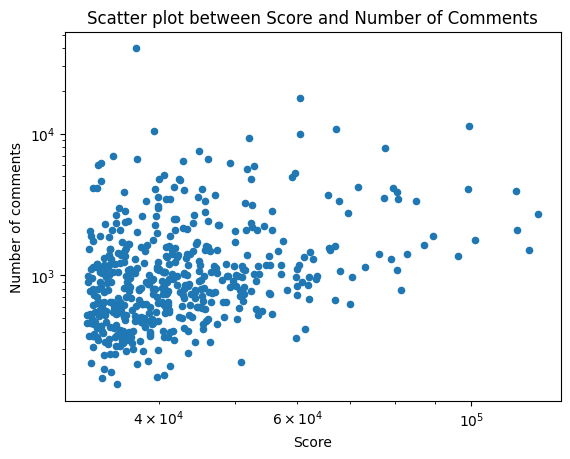

In [65]:
# See the relationship between comments and upvotes 
ax = marvel_df.plot('score', 'num_comments', kind = 'scatter',logx=True, logy=True, title='Scatter plot between Score and Number of Comments')
ax.set(xlabel="Score", ylabel="Number of comments")
plt.savefig("ScatterPlot",dpi=150, bbox_inches='tight',pad_inches=0.5)

In [66]:
repeating = marvel_df[marvel_df.duplicated(['author'], keep = False)] # Only take users who posted more than once

In [67]:
repeating = repeating[repeating.author != 'None'] # Get rid of deleted users

In [68]:
repeating.author.nunique() # Out of 500 posts, this is the amount of people who posted more than once 

36

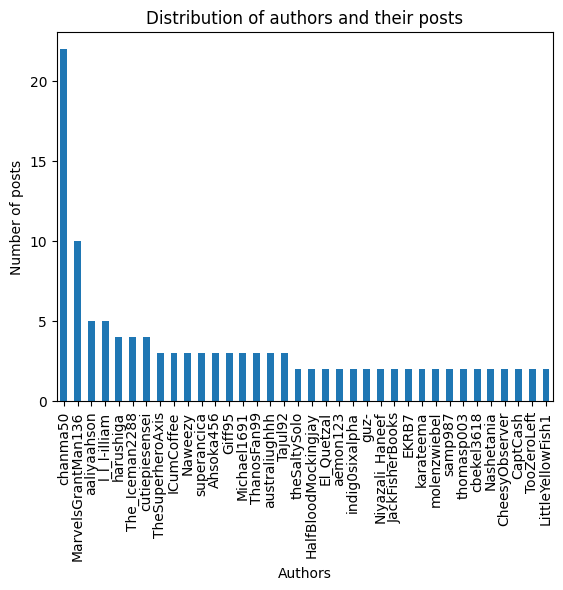

In [69]:
# See the distrubution of authors and their posts
ax = repeating.author.value_counts().plot(kind='bar',title='Distribution of authors and their posts') 
ax.set(xlabel="Authors", ylabel="Number of posts")
plt.savefig("Bargraph",dpi=150, bbox_inches='tight',pad_inches=0.5)

In [72]:
# Compiling a list of authors that appeared more than once on subreddit's top of all times 
# (Used for network graph and for get_user_posts function)
u_authors = list(repeating.author.unique()) 

In [74]:
authors_df =  pd.DataFrame() # Makes an empty dataframe
authors_df = authors_df.fillna(0)
for u in u_authors: # Loops through every "influencer" user and gets 10 top posts per user
    try:
        c = get_user_posts(u, 10)
    except:
        continue
    authors_df = pd.concat([authors_df, c]) 

In [75]:
authors_df = authors_df.rename(index=str, #renaming column names 
                               columns={0: "id", 1: "score", 2: "author", 3: "num_comments", 4: "subreddit"})

In [76]:
authors_df.head(10) # Dataframe of other subreddits where authors posted 

,id,score,author,num_comments,subreddit
0,u27agl,104102,chanma50,4797,movies
1,pj9wf8,101016,chanma50,1769,marvelstudios
2,cgbt3j,97517,chanma50,4552,movies
3,dt3ejz,86358,chanma50,3800,movies
4,ihrk4f,82374,chanma50,1417,movies
5,xb0ufz,80551,chanma50,1430,pics
6,pjqwpl,80318,chanma50,5234,movies
7,oa8a7i,80210,chanma50,4108,movies
8,kez0j2,79328,chanma50,3172,movies
9,lcgakt,79319,chanma50,1869,movies


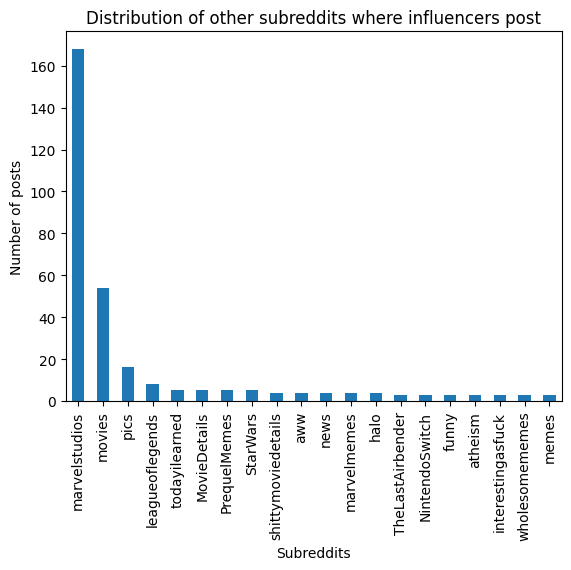

In [77]:
counts = authors_df['subreddit'].value_counts() 
# Only plot the subreddits that appear more than twice
ax = authors_df[authors_df['subreddit'].isin(counts[counts > 2].index)].subreddit.value_counts().plot(kind='bar',title='Distribution of other subreddits where influencers post') 
ax.set(xlabel="Subreddits", ylabel="Number of posts")
plt.savefig("BargraphSubreddits",dpi=150, bbox_inches='tight',pad_inches=0.5)

# Network Analysis

## Initial approach

In [78]:
n_df = authors_df[['author', 'subreddit']] # Create a dataframe for network graph purposes 
n_df.head()

,author,subreddit
0,chanma50,movies
1,chanma50,marvelstudios
2,chanma50,movies
3,chanma50,movies
4,chanma50,movies


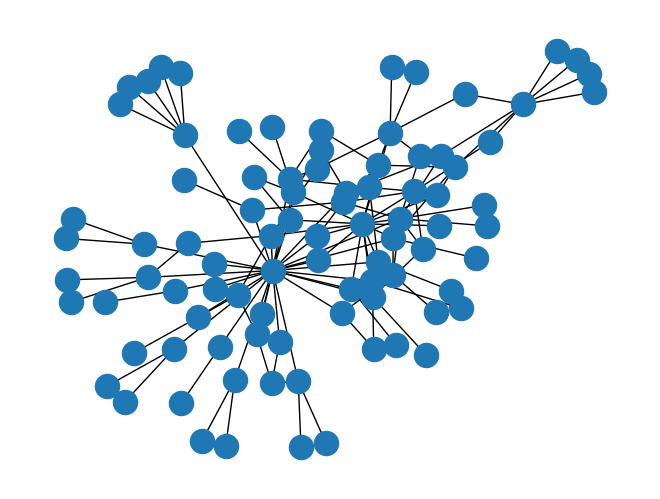

In [80]:
g = nx.from_pandas_edgelist(n_df, source='author', target='subreddit') # Initial ugly approach, decided to keep it
nx.draw(g)

## Final Approach

In [86]:
subs = list(n_df.subreddit.unique()) # Make list of unique subreddits to use in network graph
print(u_authors)

['chanma50', 'samp987', 'aaliyaahson', 'thomasp003', 'CheesyObserver', 'cutiepiesensei', 'TheSuperheroAxis', 'MarvelsGrantMan136', 'australiughhh', 'ThanosFan99', 'TooZeroLeft', 'CaptCash', 'l_l_l-illiam', 'Nashetania', 'cbekel3618', 'Michael1691', 'harushiga', 'Ahsoka456', 'The_Iceman2288', 'molenzwiebel', 'karateema', 'JackFisherBooks', 'Naweezy', 'EKRB7', 'ICumCoffee', 'Tajul92', 'Niyazali_Haneef', 'guz-', 'superancica', 'Giff95', 'theSaltySolo', 'HalfBloodMockingjay', 'El_Quetzal', 'aemon123', 'indig0sixalpha', 'LittleYellowFish1']


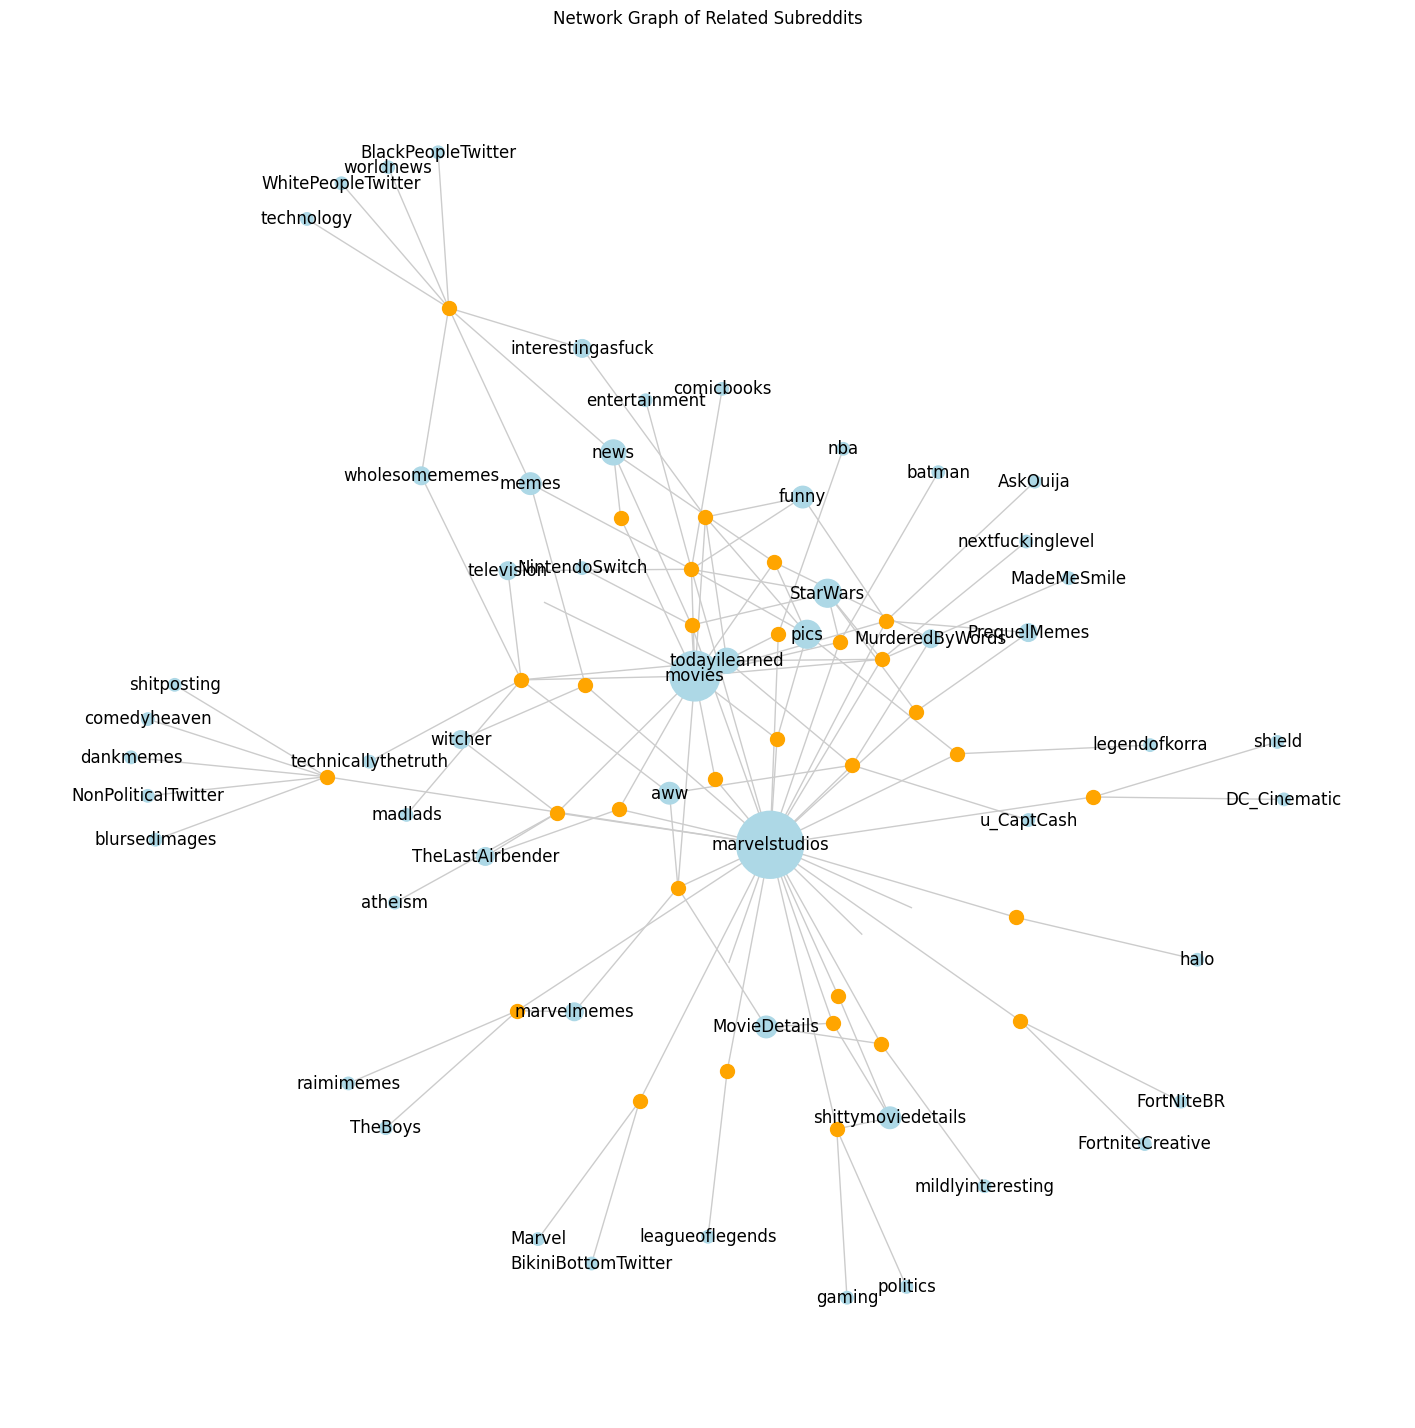

In [87]:
plt.figure(figsize=(18, 18))

# Create the graph from the dataframe
g = nx.from_pandas_edgelist(n_df, source='author', target='subreddit') 

# Create a layout for nodes 
layout = nx.spring_layout(g,iterations=50,scale=2)

# Draw the parts we want, edges thin and grey
# Influencers appear small and grey
# Subreddits appear in blue and sized according to their respective number of connections.
# Labels for subreddits ONLY
# People who have more connections are highlighted in color 

# Go through every subbreddit, ask the graph how many connections it has. 
# Multiply that by 80 to get the circle size
sub_size = [g.degree(sub) * 80 for sub in subs]
nx.draw_networkx_nodes(g, 
                       layout, 
                       nodelist=subs, 
                       node_size=sub_size, # a LIST of sizes, based on g.degree
                       node_color='lightblue')

# Draw all the entities 

#nx.draw_networkx_nodes(g, layout, nodelist=u_authors, node_color='#cccccc', node_size=100)

# Draw highly connected influencers
popular_people = []
for person in u_authors:
    try:
        if g.degree[person] > 1:
            popular_people.append(person)
    except:
        continue
# popular_people = [person for person in u_authors if g.degree[person] > 1]
nx.draw_networkx_nodes(g, layout, nodelist=popular_people, node_color='orange', node_size=100)

nx.draw_networkx_edges(g, layout, width=1, edge_color="#cccccc")

node_labels = dict(zip(subs, subs)) #labels for subs
nx.draw_networkx_labels(g, layout, labels=node_labels)

# No axis needed
plt.axis('off')
plt.title("Network Graph of Related Subreddits")
plt.savefig("NetworkGraph", bbox_inches='tight',pad_inches=0.5)
plt.show()

In [88]:
g.degree('movies') # To check the number of out-degrees for a subreddit, if interested 

16